**Problem Statement**

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [30]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [31]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166



**Loading Dataset by mounting the google drive bold text**

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [33]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

### Create a dataset

Define some parameters for the loader:

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [37]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset



In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7003 files belonging to 9 classes.
Using 5603 files for training.


In [39]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7003 files belonging to 9 classes.
Using 1400 files for validation.


In [41]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [42]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [43]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


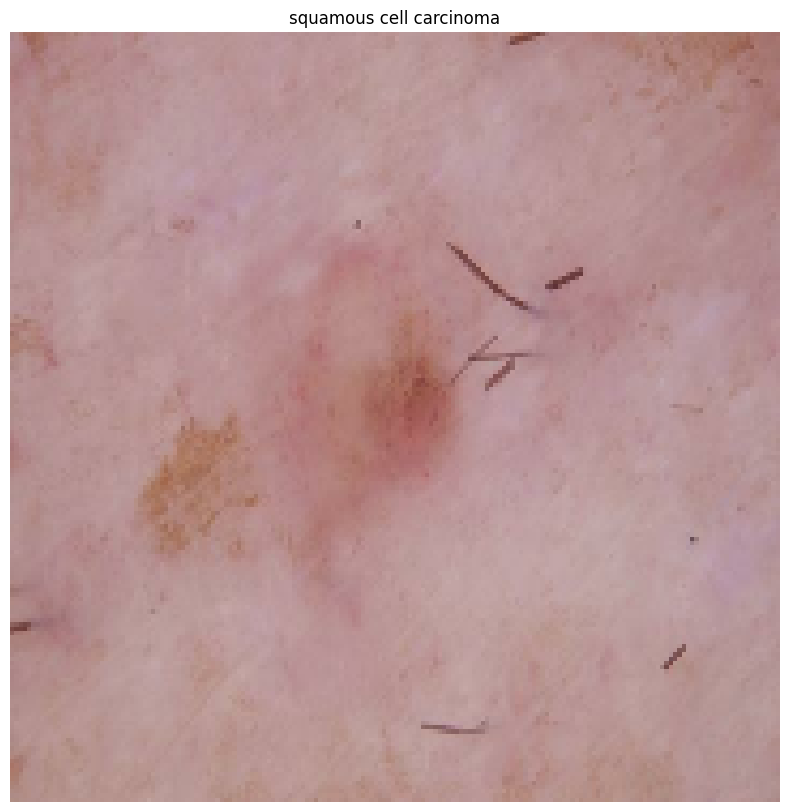

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[1].numpy().astype("uint8"))
  plt.title(class_names[labels[1]])
  plt.axis("off")


**Visualize the data**

create a code to visualize one instance of all the nine classes present in the dataset

In [45]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

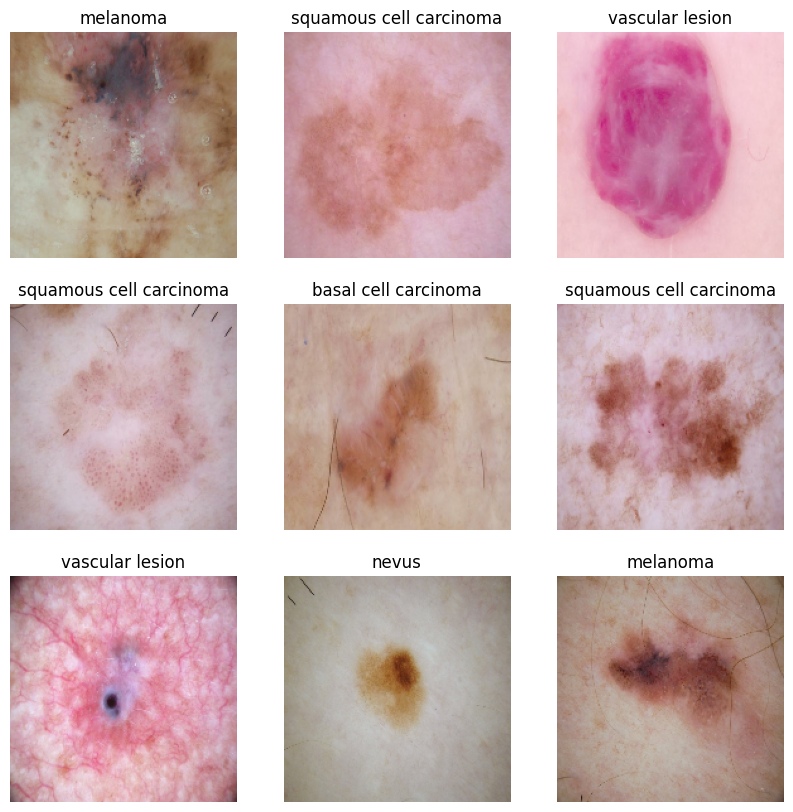

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [48]:
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [50]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the model**

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
176/176 [==============================] - 44s 80ms/step - loss: 2.0284 - accuracy: 0.2340 - val_loss: 1.6869 - val_accuracy: 0.3714
Epoch 2/20
176/176 [==============================] - 4s 23ms/step - loss: 1.5273 - accuracy: 0.4210 - val_loss: 1.5483 - val_accuracy: 0.3893
Epoch 3/20
176/176 [==============================] - 4s 23ms/step - loss: 1.3096 - accuracy: 0.5044 - val_loss: 1.2964 - val_accuracy: 0.5136
Epoch 4/20
176/176 [==============================] - 4s 22ms/step - loss: 1.1188 - accuracy: 0.5833 - val_loss: 1.2571 - val_accuracy: 0.5550
Epoch 5/20
176/176 [==============================] - 4s 22ms/step - loss: 0.9337 - accuracy: 0.6564 - val_loss: 1.0506 - val_accuracy: 0.6171
Epoch 6/20
176/176 [==============================] - 4s 23ms/step - loss: 0.7576 - accuracy: 0.7173 - val_loss: 1.0136 - val_accuracy: 0.6543
Epoch 7/20
176/176 [==============================] - 4s 22ms/step - loss: 0.6148 - accuracy: 0.7828 - val_loss: 0.9947 - val_accuracy: 0.676

In [52]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

**Visualizing training results**

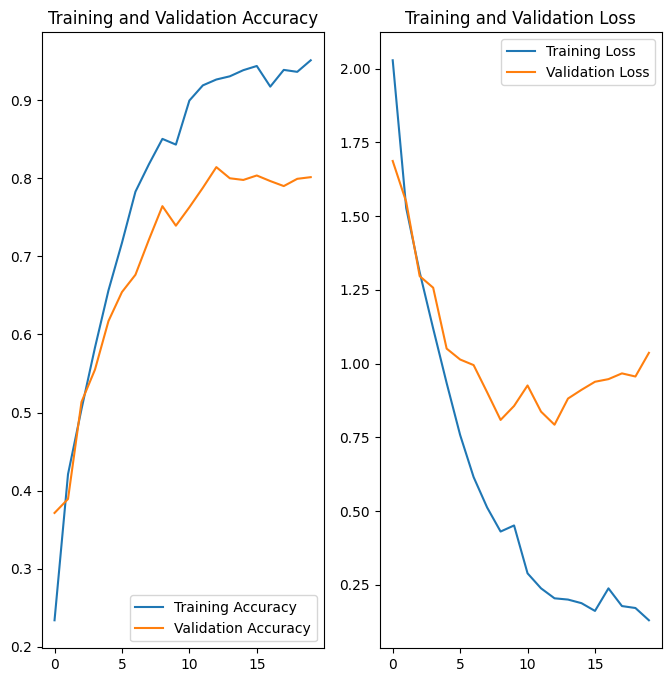

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

***Findings/Observations***

1. The accuracy of the model for the Training data set is at ~96%. But the Validation accuracy is not in par with the training accuracy.
It is only at ~80%.
2. The validation loss as observed is very high. This can also indicate that the model might get overfit.
3. We could add some Dropout layers and remove the BatchNormalization layers. And by adding a few more layers, we could improve the accuracy by trying to extract more features.

In [54]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

In [55]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

In [56]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

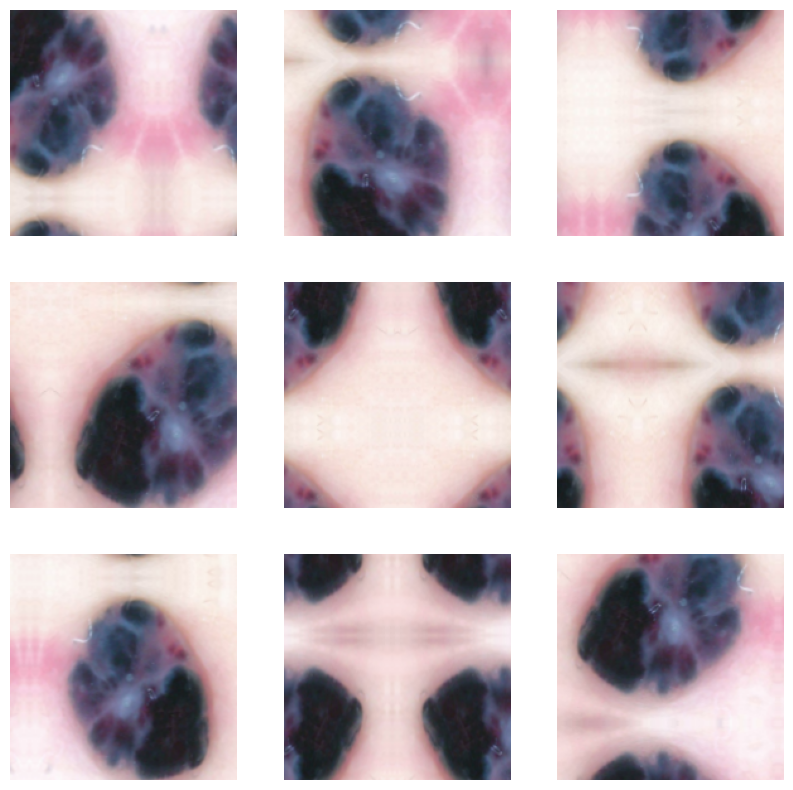

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create the model, compile and train the model**

In [58]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

In [59]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


**Compiling the model**


In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the model**

In [61]:
## Your code goes here, note: train your model for 20 epochs

In [63]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
176/176 [==============================] - 20s 115ms/step - loss: 1.3421 - accuracy: 0.4835 - val_loss: 1.3217 - val_accuracy: 0.4771
Epoch 2/20
176/176 [==============================] - 20s 113ms/step - loss: 1.3376 - accuracy: 0.4753 - val_loss: 1.2955 - val_accuracy: 0.4979
Epoch 3/20
176/176 [==============================] - 20s 112ms/step - loss: 1.3209 - accuracy: 0.4880 - val_loss: 1.2667 - val_accuracy: 0.5014
Epoch 4/20
176/176 [==============================] - 20s 114ms/step - loss: 1.3021 - accuracy: 0.4938 - val_loss: 1.2249 - val_accuracy: 0.5350
Epoch 5/20
176/176 [==============================] - 20s 113ms/step - loss: 1.2891 - accuracy: 0.5010 - val_loss: 1.4121 - val_accuracy: 0.4564
Epoch 6/20
176/176 [==============================] - 20s 113ms/step - loss: 1.3413 - accuracy: 0.4872 - val_loss: 1.2916 - val_accuracy: 0.5164
Epoch 7/20
176/176 [==============================] - 20s 112ms/step - loss: 1.3003 - accuracy: 0.5038 - val_loss: 1.2647 - val_ac

**Visualizing the results**

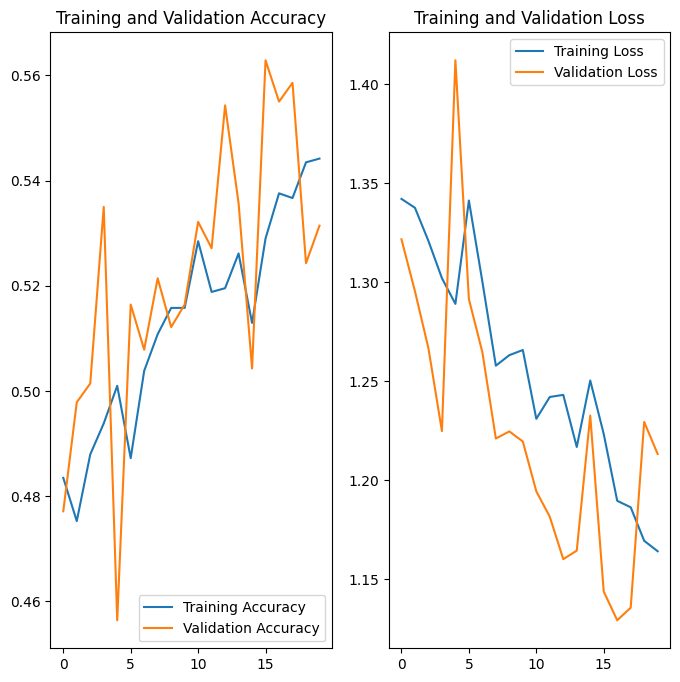

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Findings/Observations***

1. The accuracy for the train set is ~54%

2. The accuracy for the Validation set is also at ~53%.
Though the model accuracy for train and validation data had decreased when compared to the first model, as the accuracy scores are close to each other, this model is better than the first model.

3. Hence, we can say that Data Augmentation has definitely improved the model performance.

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [66]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [67]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,melanoma
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,melanoma
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,melanoma
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,melanoma


Class=0, n=114 (5.092%)
Class=6, n=77 (3.439%)
Class=4, n=357 (15.945%)
Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)
Class=8, n=139 (6.208%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)


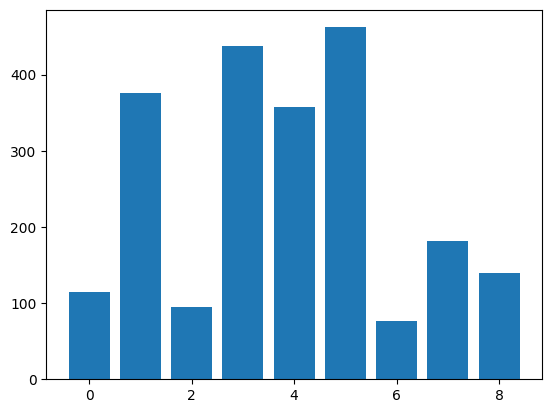

In [68]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Todo: Write your findings here:

*There is a huge different in the number of samples for each class and the data is clearly imbalanced.*

- Which class has the least number of samples?

  Ans: **'seborrheic keratosis'** has got the least number of samples i.e. 77.

- Which classes dominate the data in terms proportionate number of samples?

  Ans: **'pigmented benign keratosis'** has the highest number of samples i.e, 462, followed by 'melanoma' which has 438 samples.*

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [69]:
!pip install Augmentor

In [70]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(150)
p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E06A1228220>: 100%|██████████| 150/150 [00:09<00:00, 15.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E06A25C8160>: 100%|██████████| 114/114 [00:05<00:00, 19.98 Samples/s]


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [71]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E06BF955FF0>: 100%|██████████| 500/500 [00:23<00:00, 21.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E06A037E200>: 100%|██████████| 500/500 [00:19<00:00, 25.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E07418B67A0>: 100%|██████████| 500/500 [00:19<00:00, 25.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E06A037E2C0>: 100%|██████████| 500/500 [01:43<00:00,  4.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E07418B70D0>: 100%|██████████| 500/500 [01:43<00:00,  4.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E06A18118D0>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E06A23155A0>: 100%|██████████| 500/500 [00:50<00:00,  9.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E06BD94DAB0>: 100%|██████████| 500/500 [00:20<00:00, 23.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E06A024A8F0>: 100%|██████████| 500/500 [00:19<00:00, 25.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [72]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


9528


### Lets see the distribution of augmented data after adding new images to the original training data.

In [73]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_59e04565-c5eb-474b-8cc4-83dc6534d4cf.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_fe03983e-760f-41ae-9752-6f0a592d0d57.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_8b93ace7-3b94-4311-abfe-cfbd10f53685.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_de905632-de5f-4e9e-8288-6b6d314dc0fc.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [74]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [75]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [76]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-76-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [77]:
new_df['Label'].value_counts()

actinic keratosis             1642
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [78]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [79]:
#data_dir_train="path to directory with training data + data created using augmentor"


In [80]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11767 files belonging to 9 classes.
Using 9414 files for training.


#### **Todo:** Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation' ,## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11767 files belonging to 9 classes.
Using 2353 files for validation.


**Todo:** Create your model (make sure to include normalization)

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [84]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
295/295 [==============================] - 80s 100ms/step - loss: 1.6325 - accuracy: 0.3845 - val_loss: 1.4190 - val_accuracy: 0.4603
Epoch 2/30
295/295 [==============================] - 8s 29ms/step - loss: 1.1431 - accuracy: 0.5850 - val_loss: 0.9758 - val_accuracy: 0.6715
Epoch 3/30
295/295 [==============================] - 9s 30ms/step - loss: 0.7801 - accuracy: 0.7243 - val_loss: 0.6974 - val_accuracy: 0.7425
Epoch 4/30
295/295 [==============================] - 9s 29ms/step - loss: 0.5175 - accuracy: 0.8170 - val_loss: 0.5573 - val_accuracy: 0.8185
Epoch 5/30
295/295 [==============================] - 9s 30ms/step - loss: 0.4018 - accuracy: 0.8632 - val_loss: 0.5380 - val_accuracy: 0.8156
Epoch 6/30
295/295 [==============================] - 9s 29ms/step - loss: 0.3033 - accuracy: 0.8935 - val_loss: 0.4274 - val_accuracy: 0.8721
Epoch 7/30
295/295 [==============================] - 9s 29ms/step - loss: 0.2287 - accuracy: 0.9193 - val_loss: 0.4191 - val_accuracy: 0.86

#### **Todo:**  Visualize the model results

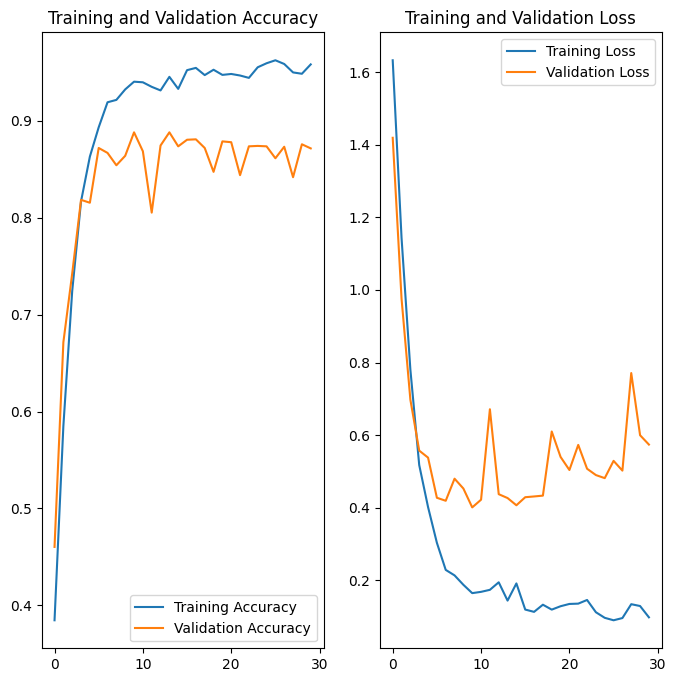

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

***Findings/Observations:***
1. The training accuracy seems to be nearly ~95%.
2. The validation accuracy is nearly ~87%.
3. **Though the model accuracy has improved, the augmentation and class rebalance has helped treat the overfitting.**

**Model Predictions**

Predictions on the test data using this model

Found 11767 files belonging to 9 classes.
Found 118 files belonging to 9 classes.
{'actinic keratosis': 0, 'basal cell carcinoma': 0, 'dermatofibroma': 0, 'melanoma': 0, 'nevus': 0, 'pigmented benign keratosis': 0, 'seborrheic keratosis': 0, 'squamous cell carcinoma': 0, 'vascular lesion': 0}
1/1 [==============================] - 0s 60ms/step


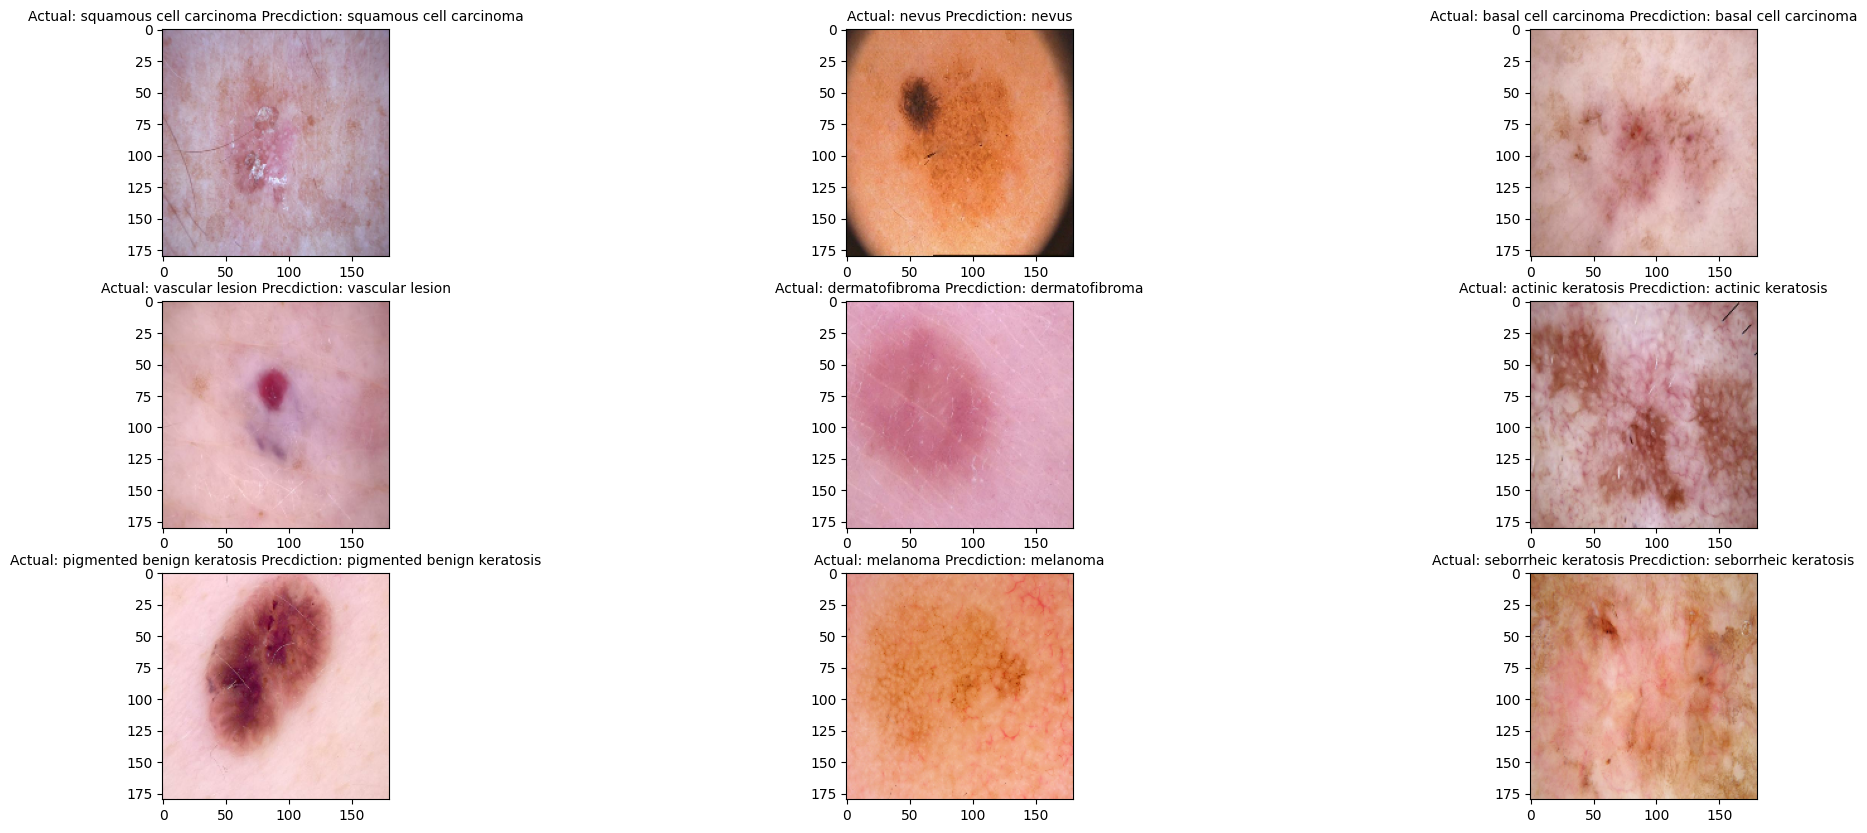

In [87]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

#Using keras to read dataset
mel_dataset=tf.keras.utils.image_dataset_from_directory(data_dir_train,labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    seed=123)

# Loading the Test Dataset for model predictions
mel_test_dataset=tf.keras.utils.image_dataset_from_directory(data_dir_test,labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    seed=123)

label_test=mel_test_dataset.class_names


# Class Wise prediction for Test dataset
index=1
label_test_dict = {key: 0 for key in label_test}
plt.figure(figsize=(25,10))
print(label_test_dict)
for images,labels in mel_dataset:
    label1=labels[0]
    class_index=tf.argmax(label1)
    if(label_test_dict[label_test[class_index]]==0):
        image=images[0]
        # Predicting for image from each class
        img = np.expand_dims(image,axis=0)
        pred = model.predict(img)
        pred = np.argmax(pred)
        pred_class = label_test[pred]
        plt.subplot(3,3,index)
        plt.imshow(image.numpy().astype("uint8"))
        # Displaying Predicted class of Image in Title along with the actual class of image
        plt.title("Actual: "+label_test[class_index]+" Precdiction: "+pred_class,fontsize=10)
        index=index+1
        label_test_dict[label_test[class_index]]+=1

plt.show()

**Observations:**
1. If we obesrve the text above the images here, we can see that that actual and the predicted values are correct.Model is able to predict well. Eg: **Image-1** the **Actual** value is **squamous cell carcinoma** and the **Predicted** value is also **squamous cell carcinoma**
2. **Model Accuracy:**

  Validation Accuracy: 87%

  Traning Accuracy: 95%
